In [17]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras_cv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.optimizers import schedules
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix


In [18]:
def get_data():
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

    assert x_train_full.shape == (60000, 28, 28)
    assert x_test.shape == (10000, 28, 28)
    assert y_train_full.shape == (60000,)
    assert y_test.shape == (10000,)

    x_train, y_train = x_train_full[:-5000], y_train_full[:-5000]
    x_valid, y_valid = x_train_full[-5000:], y_train_full[-5000:]

    assert x_train.shape == (55000, 28, 28)
    assert x_valid.shape == (5000, 28, 28)
    assert y_train.shape == (55000,)
    assert y_valid.shape == (5000,)

    #normalising
    return x_train / 255., x_valid / 255., x_test / 255., y_train, y_valid, y_test
    

In [19]:
#Setting seed for reproducible results
tf.random.set_seed(100)

In [20]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
num_classes = len(class_names)

In [21]:
def make_graphs(x_train, y_train, include_prediction=False, x_test_pred=None):
    num_imgs = 16
    plt.figure(figsize=(4*4, num_imgs//4*5))
    for i in range(num_imgs):
        plt.subplot(num_imgs//4, 4, i + 1)
        img = x_train[i] 
        target = class_names[y_train[i]]
        plt.imshow(img, cmap="gray")
        if include_prediction:
            prediction = class_names[np.argmax(x_test_pred[i])]
            plt.title(f"Target: {target}. Prediction: {prediction}")
        else:
            plt.title(f"Target: {target}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

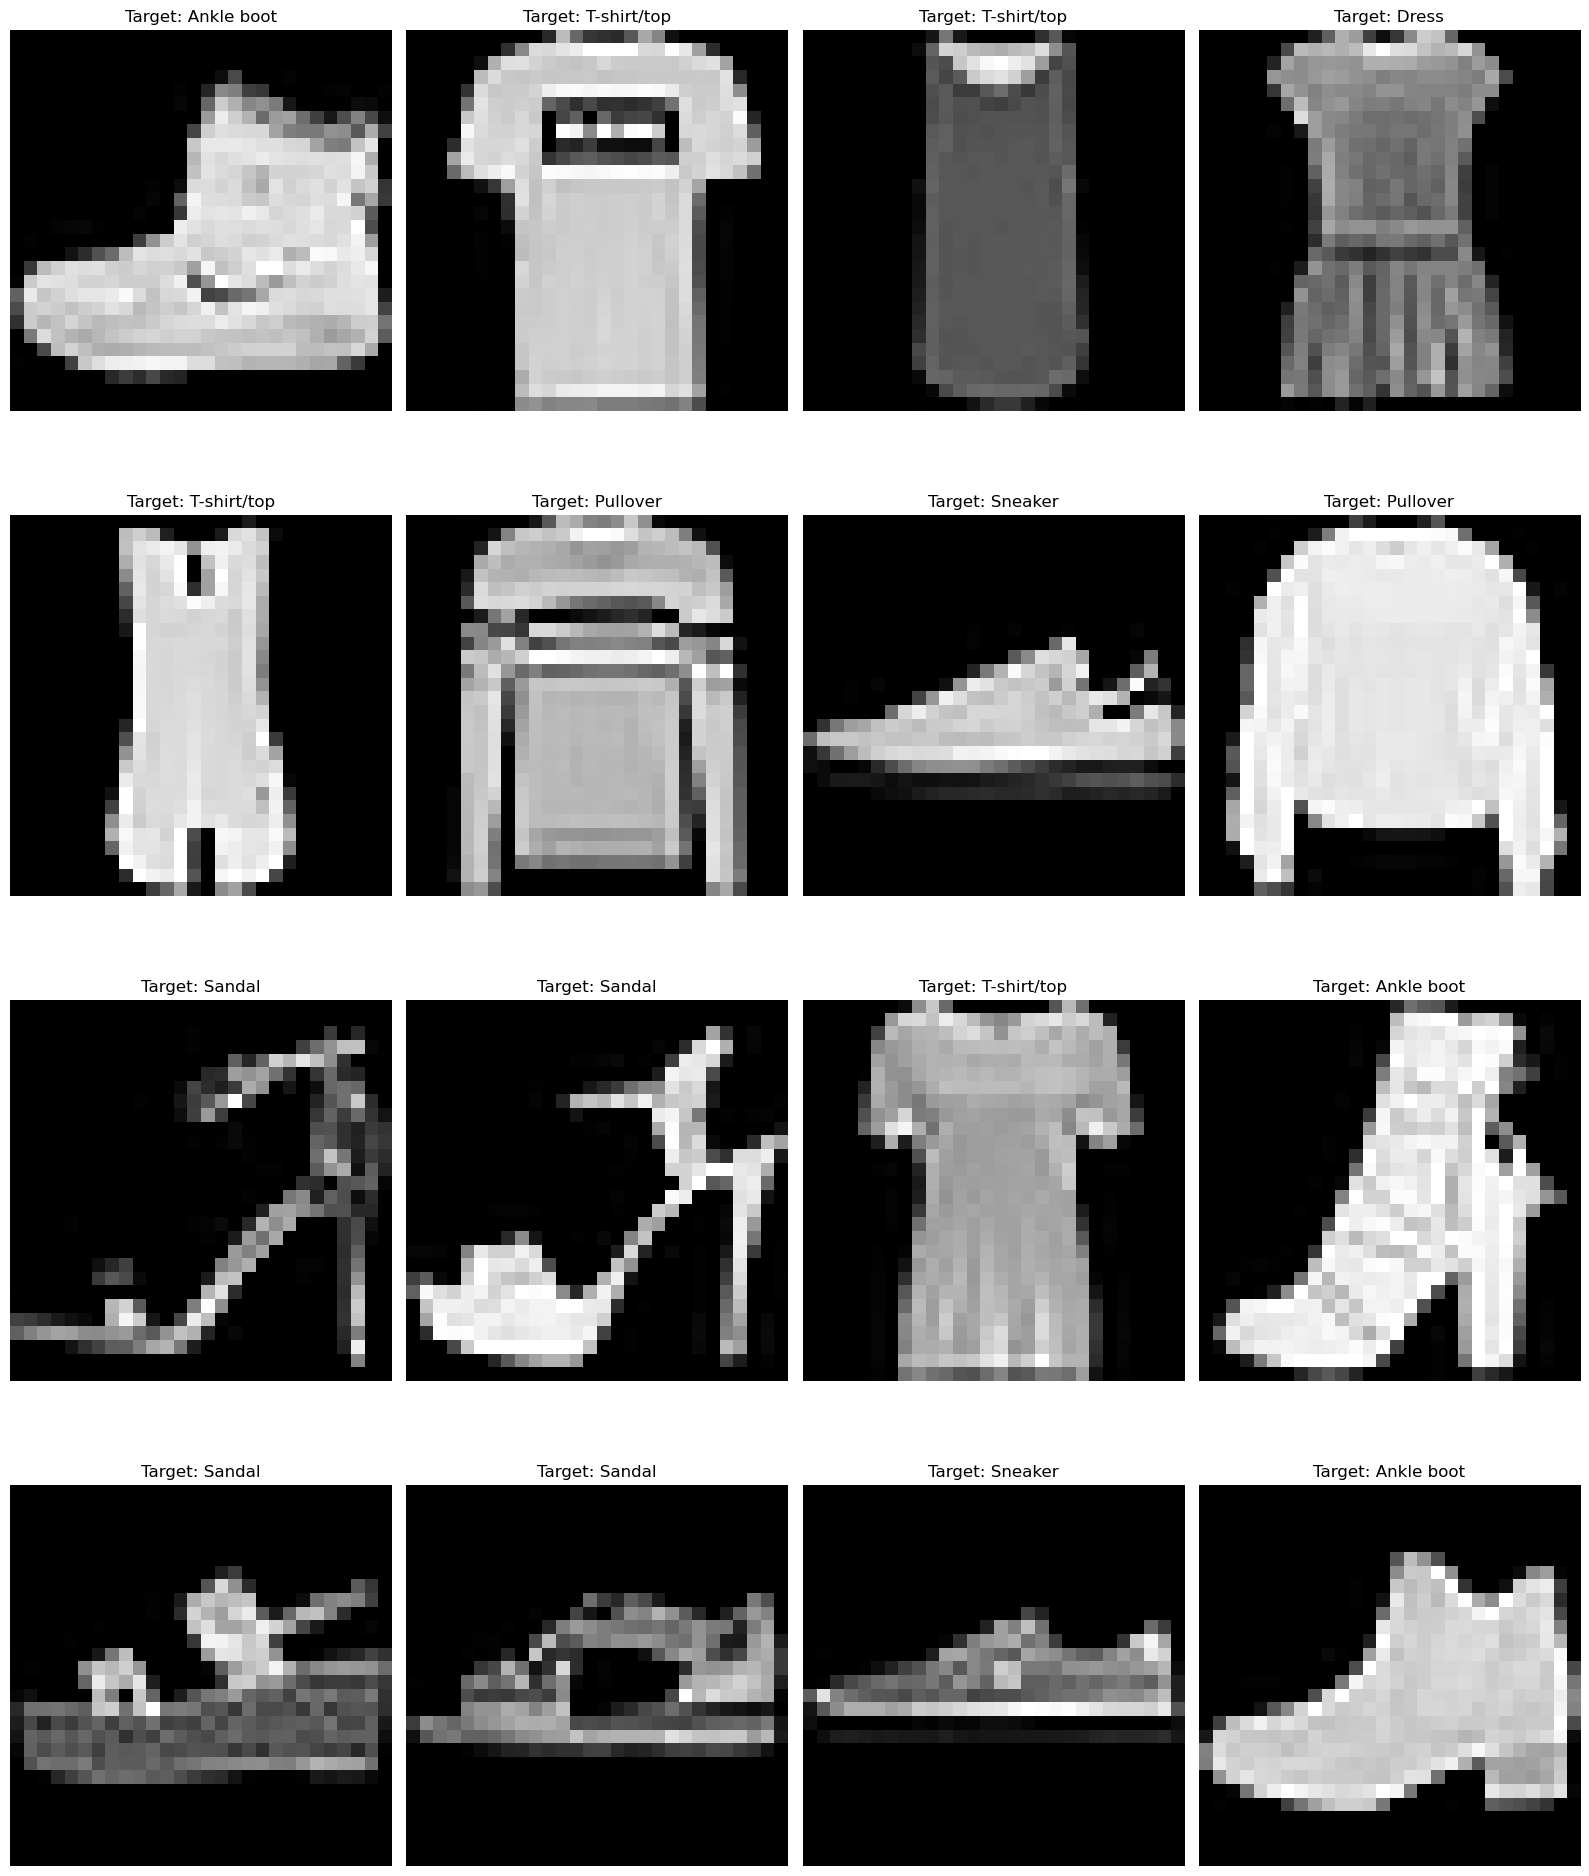

In [22]:
#Plots of the raw data, with class name labels
x_train, x_valid, x_test, y_train, y_valid, y_test = get_data()
make_graphs(x_train, y_train)

In [23]:
#Apply augmentations using keras_cv, helps to prevent overfitting.
def build_augmenter():
    augmenters = [
        keras_cv.layers.RandomShear(x_factor=0.05,y_factor=0.05),
        keras_cv.layers.RandomCutout(width_factor=(0.01, 0.05),height_factor=(1.0, 1.0)),
        keras_cv.layers.RandomCutout(width_factor=(1.0, 1.0),height_factor=(0.01, 0.05))
    ]
    
    def augment(image):
        for augmenter in augmenters:
            image = augmenter(image)
        return image
    
    return augment


In [24]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
augmenter = build_augmenter()
x_train = augmenter(x_train)

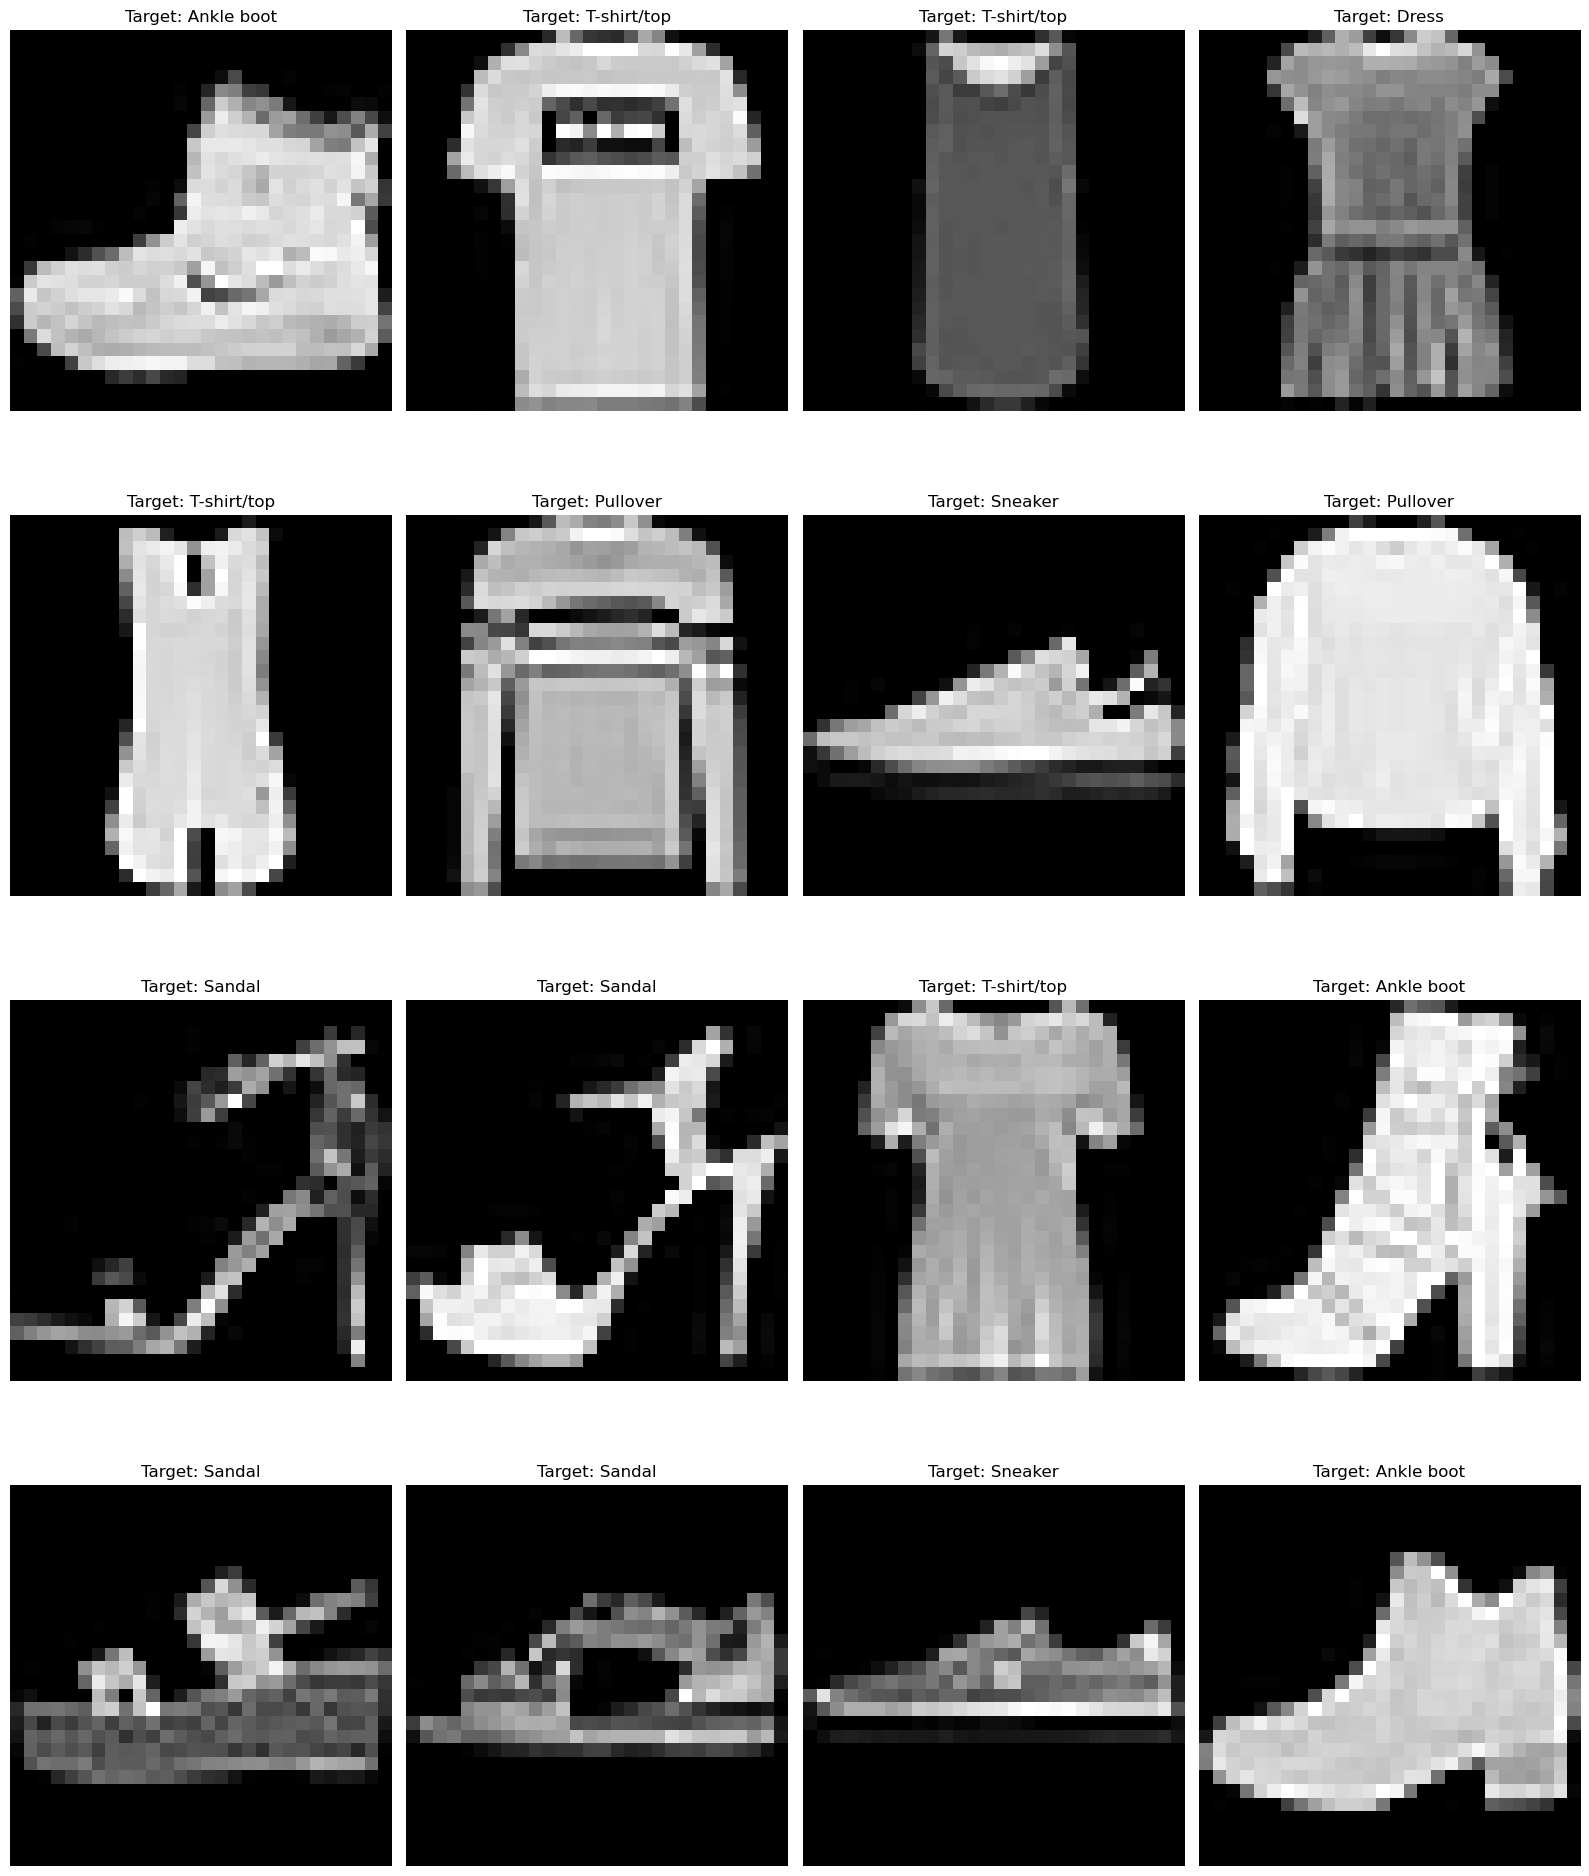

In [25]:
#Plots of the augmented data, with class name labels
make_graphs(x_train, y_train)


In [26]:
#estimating steps per epoch, presuming a (default) batch size of 32
steps_per_epoch = x_train.shape[0] / 32
print(steps_per_epoch)

1718.75


In [27]:
#Define model
from functools import partial
def get_model(plot=False, summary=False, lr_scheduler="exp", initial_learning_rate=1e-3, model_type="default"):
    if model_type == "cnn":
        DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal")
        model = tf.keras.Sequential([
            DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
            tf.keras.layers.MaxPool2D(),
            DefaultConv2D(filters=128),
            DefaultConv2D(filters=128),
            tf.keras.layers.MaxPool2D(),
            DefaultConv2D(filters=256),
            DefaultConv2D(filters=256),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(units=10, activation="linear")
        ], name="my_model_cnn")
    else:
        model = Sequential(
        [               
            tf.keras.Input(shape=(28, 28)),
            Flatten(),
            Dense(500, activation='relu', name = "L0"),
            Dense(300, activation='relu', name = "L1"),
            Dense(100, activation='relu',  name = "L2"),
            Dense(10, activation='linear', name = "L3"),
        ], name = "my_model")
        
    
    if lr_scheduler == "exp":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=25000,
        decay_rate=0.1)
    elif lr_scheduler == "cosine":
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=20000,
        alpha=initial_learning_rate/100)
    
    #Plot of LR scheduler
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(20000), [lr_schedule.__call__(epoch) for epoch in np.arange(20000)], marker='o')
        plt.xlabel('Steps'); plt.ylabel('Learning Rate')
        plt.title('LR Scheduler')
        plt.show()

    # Compile the model  
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    # Model Sumamry
    if summary:
        model.summary()
    
    return model

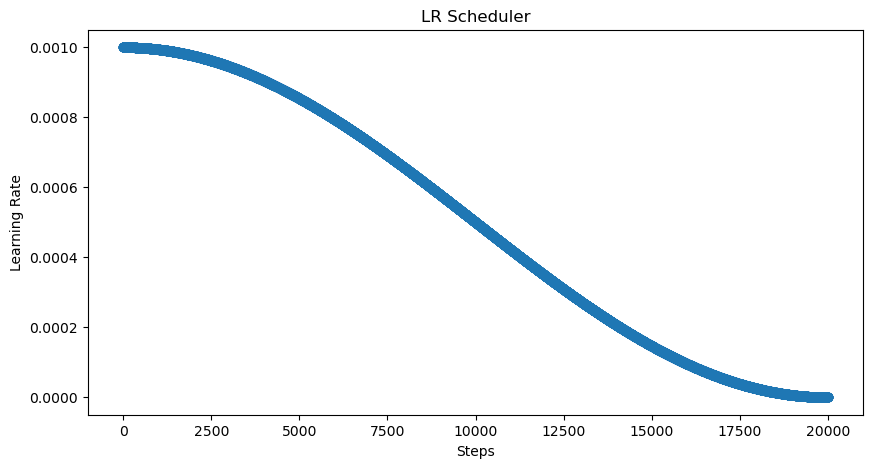

Model: "my_model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 7, 256)        

In [39]:
get_model(True, True, lr_scheduler="cosine", model_type="cnn")

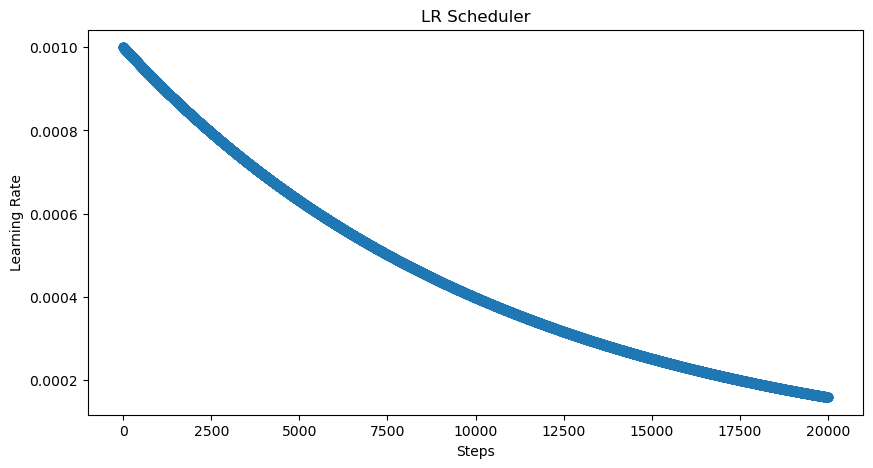

Model: "my_model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 7, 7, 256)        

In [40]:
get_model(True, True, lr_scheduler="exp", model_type="cnn")

In [30]:
def full_flow(augment=True, epochs=50, lr_scheduler="exp", initial_learning_rate=1e-3, early_stopping_patience=5):
    x_train, x_valid, x_test, y_train, y_valid, y_test = get_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    if augment:
        x_train = build_augmenter()(x_train)
    model = get_model(False, False, lr_scheduler, initial_learning_rate, model_type="cnn")
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)
    history = model.fit(x_train, y_train, callbacks=[early_stopping_cb], epochs=epochs, validation_data=(x_valid, y_valid), batch_size=32)
    return model, history

In [31]:
steps_per_epoch = x_train.shape[0] / 32
steps_per_epoch

1718.75

In [32]:
trained_model_augmented_exp, history_augmented_exp = full_flow(augment=True, lr_scheduler="exp")
trained_model_augmented_cosine, history_augmented_cosine = full_flow(augment=True, lr_scheduler="cosine")
trained_model_exp, history_exp = full_flow(augment=False, lr_scheduler="exp")
trained_model_cosine, history_cosine = full_flow(augment=False, lr_scheduler="cosine")

Epoch 1/50
1719/1719 [==============================] - 188s 109ms/step - loss: 0.8658 - accuracy: 0.6777 - val_loss: 0.3978 - val_accuracy: 0.8614
Epoch 2/50
1719/1719 [==============================] - 185s 108ms/step - loss: 0.4692 - accuracy: 0.8362 - val_loss: 0.3125 - val_accuracy: 0.8788
Epoch 3/50
1719/1719 [==============================] - 184s 107ms/step - loss: 0.3733 - accuracy: 0.8741 - val_loss: 0.2762 - val_accuracy: 0.8922
Epoch 4/50
1719/1719 [==============================] - 187s 109ms/step - loss: 0.3142 - accuracy: 0.8932 - val_loss: 0.2652 - val_accuracy: 0.9064
Epoch 5/50
1719/1719 [==============================] - 185s 108ms/step - loss: 0.2781 - accuracy: 0.9074 - val_loss: 0.2474 - val_accuracy: 0.9130
Epoch 6/50
1719/1719 [==============================] - 186s 108ms/step - loss: 0.2386 - accuracy: 0.9207 - val_loss: 0.2417 - val_accuracy: 0.9142
Epoch 7/50
1719/1719 [==============================] - 181s 105ms/step - loss: 0.2056 - accuracy: 0.9320 - val_

<Axes: title={'center': 'Cosine LR'}, xlabel='Epoch'>

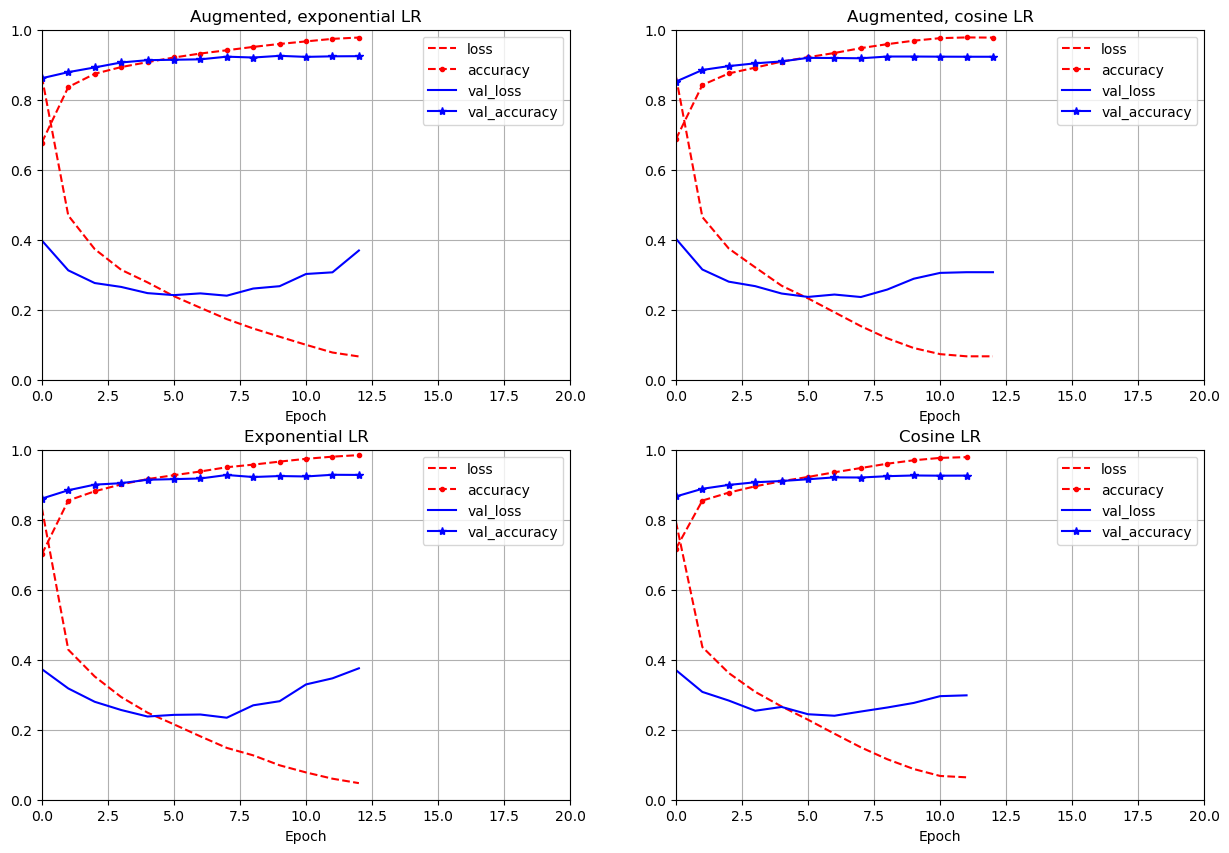

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2)

pd.DataFrame(history_augmented_exp.history).plot(title="Augmented, exponential LR", figsize=(15,10), xlim=[0,20], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[0,0])
pd.DataFrame(history_augmented_cosine.history).plot(title="Augmented, cosine LR", figsize=(15,10), xlim=[0,20], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[0,1])
pd.DataFrame(history_exp.history).plot(title="Exponential LR", figsize=(15,10), xlim=[0,20], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[1,0])
pd.DataFrame(history_cosine.history).plot(title="Cosine LR", figsize=(15,10), xlim=[0,20], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"], ax=axes[1,1])



In [34]:
trained_model_augmented_exp.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.2804 - accuracy: 0.9170


[0.2804413437843323, 0.9169999957084656]

In [35]:
x_test_pred = trained_model_augmented_exp.predict(x_test)

313/313 [==============================] - 3s 9ms/step


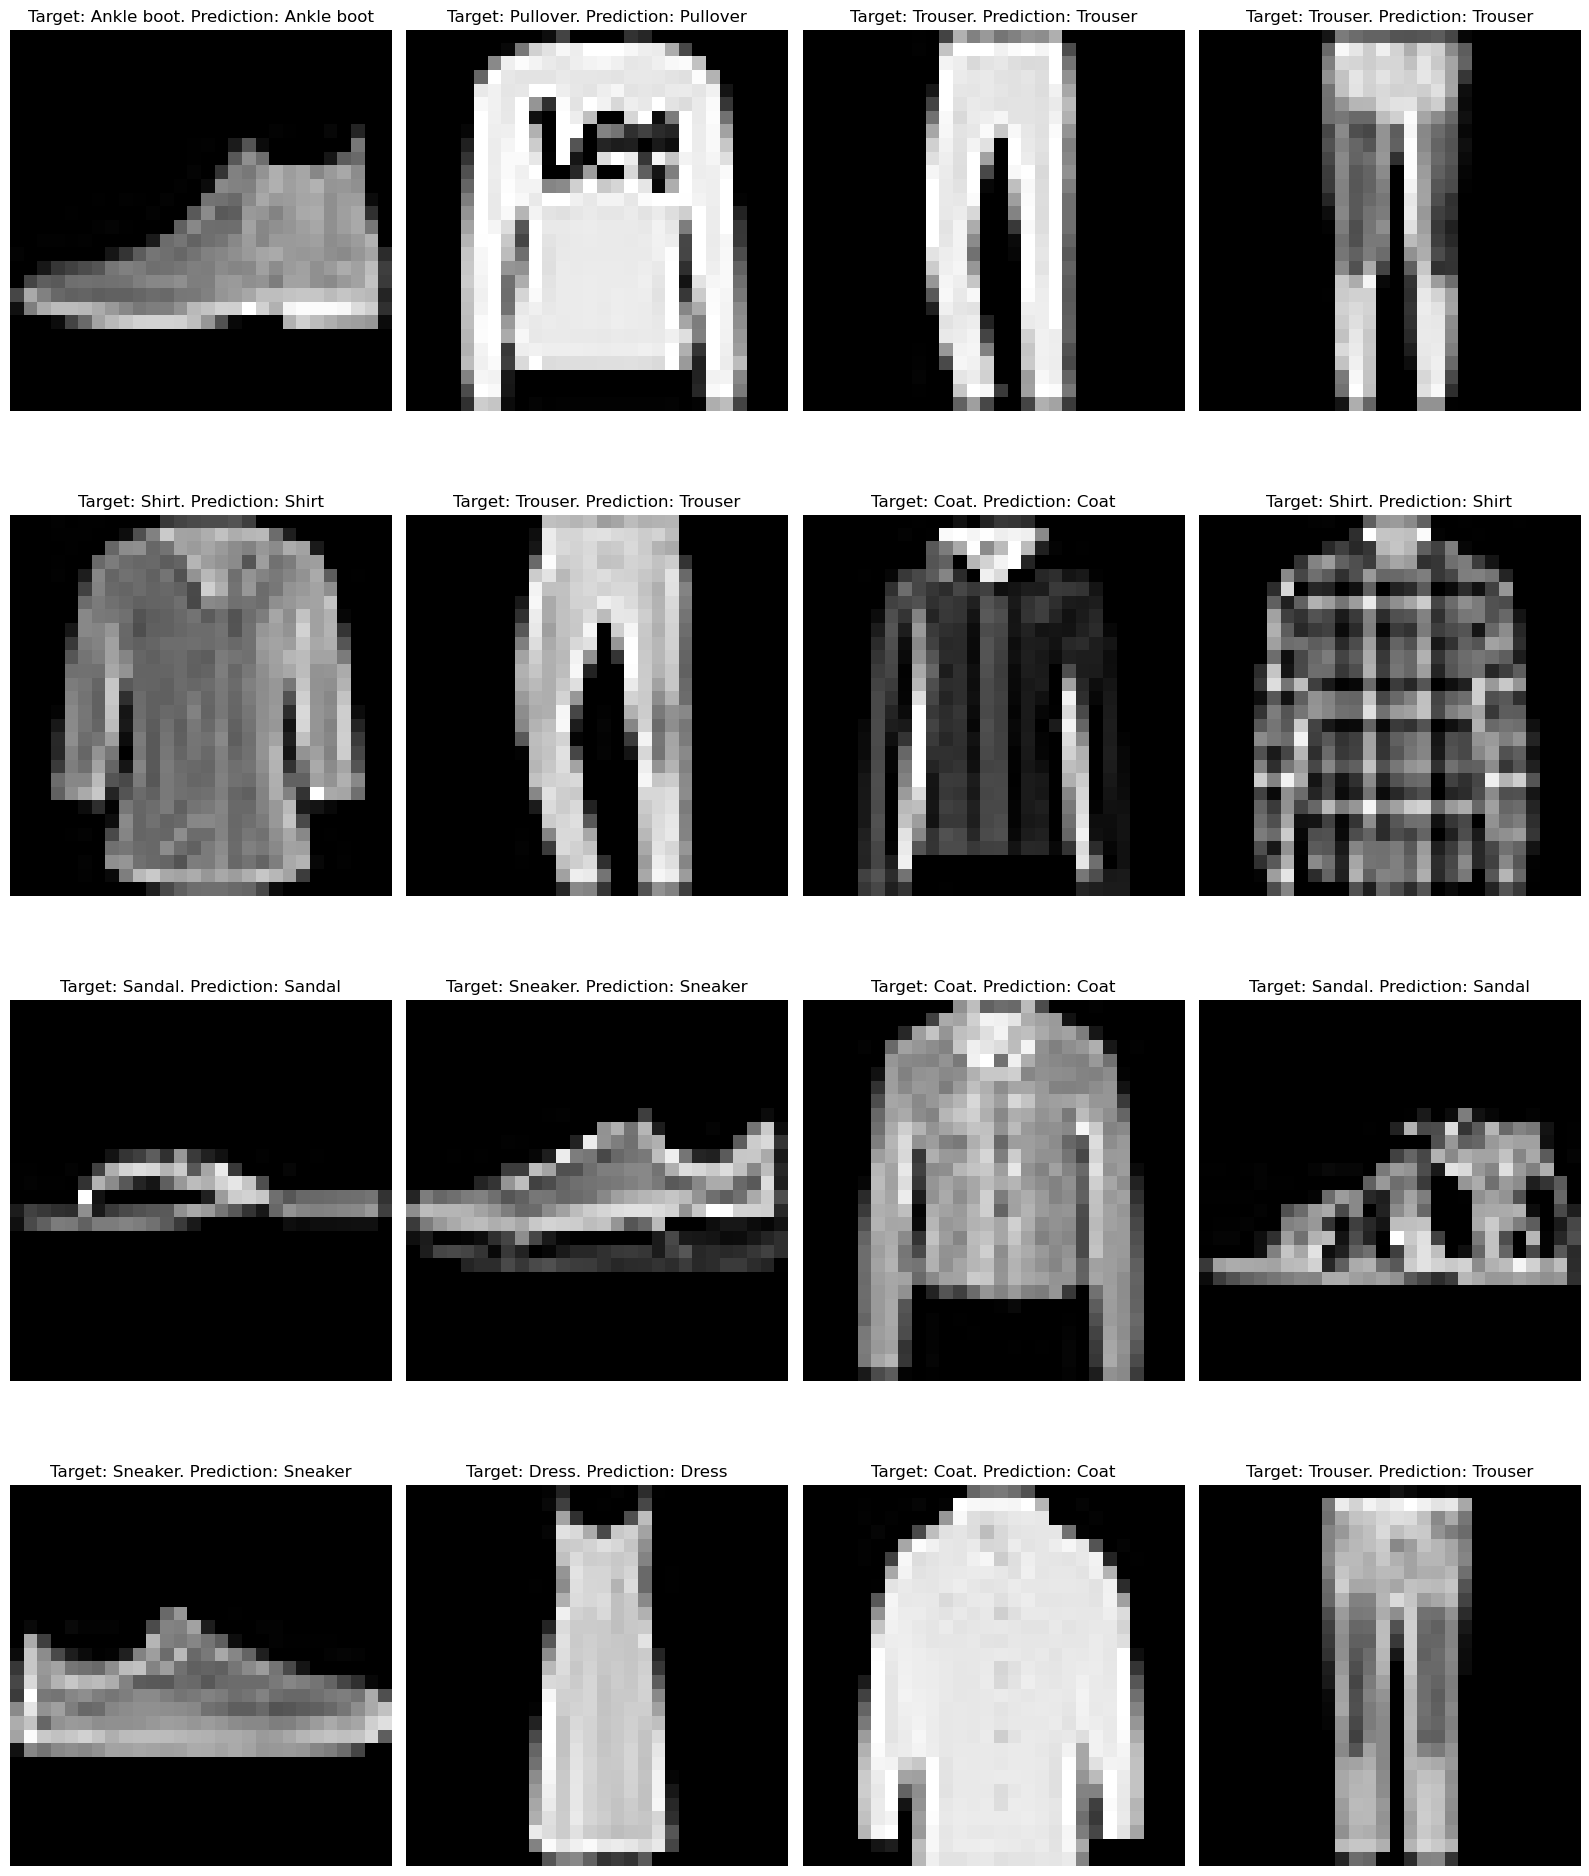

In [36]:
make_graphs(x_test, y_test, True, x_test_pred)

In [37]:
#Class distribution in dataset
x_test_pred_discrete = []
for result in x_test_pred:
    x_test_pred_discrete.append(np.argmax(result))
cm = confusion_matrix(y_test, x_test_pred_discrete)

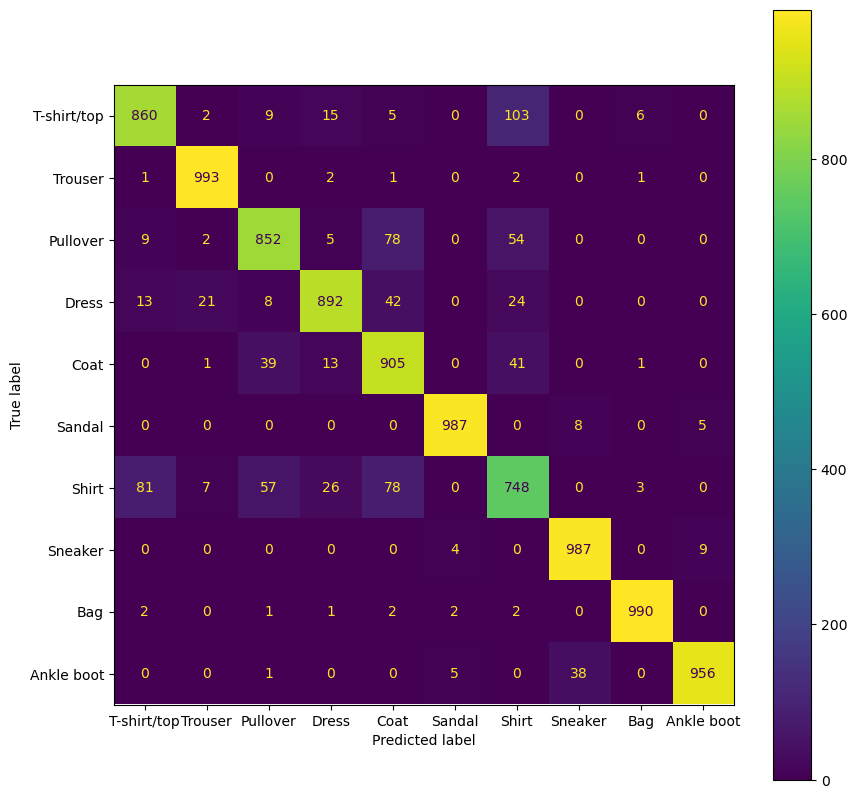

In [38]:
disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

#From confusion matrix, Shirt is the worst performing class, being misclassified as other similar looking items like T-shirt/top and pullover